# General Technical Analysis Calculator
<b>Having trouble analyzing your stock/investment portfolios?</b> <br>
<b>Sick of having to pay for overpriced calculators?</b> <br>
<b>Tired of searching the web for tips and tricks to navigate the market?</b><br>
<b>Fear not!</b> <br><br>
The following program was developed to allow amatuer investors/traders like me to gain insights into one's current <br>
positions. The program allows you to visualize your stock's performance in any particular time frame, furthermore <br>
it also allows investors/traders to visualize their stock's current trajectory, determining buying or selling <br>
opportunities. <br>
Upon entering a time frame and ticker symbol, the investor/trader will be presented with current stock data in-line <br>
with the designated time frame. It will also show trading volumes during a particular time frame. <br>



In [2]:
#Import necessary libraries and modules 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime as dt
import datetime
from datetime import datetime, timedelta
from matplotlib import gridspec
from termcolor import colored
from yahoo_fin.stock_info import get_data
import yahoo_fin.stock_info as si

In [3]:
# Read data
# Rename and reformat pricing to 2 decimal places 
def read_data(tick_symbol, start_date, end_date):
    data = get_data(tick_symbol, start_date=start_date, end_date=end_date, index_as_date = False)
    data = data.rename(columns={'date':'Date', 'high':'High', 'low':'Low', 'close':'Close', 'adjclose':'Adj Close', 'volume':'Volume'})
    lis = ['High', 'Low', 'Close', 'Adj Close']
    for i in lis:
        data[i] = data[i].round(2)
    return data

In [4]:
# visualize support/resistance levels for SMA
def show_level(graph, data, resistance):
    if resistance == 'b':
        support = graph.axhline(data['SMA'].tail(1).values, ls = '--', color = 'red')  
        resistance = graph.axhline(data['SMA'].max(), ls = '--', color = 'green')
        return (support, resistance)
    elif resistance == 's':
        return graph.axhline(data['SMA'].tail(1).values, ls = '--', color = 'red')  
    elif resistance == 'r':
        return graph.axhline(data['SMA'].max(), ls = '--', color = 'green')
    else:
        None

In [5]:
# Show current closing price of stock 
def show_price(data, input_user):
    if input_user == 'y':
        plot = plt.scatter(data['Date'].tail(1).values, data['Close Price'].tail(1).values, marker = '*', color = 'black', alpha = 1)
        label = str(data['Close Price'].tail(1).values)
        for x, y, z in zip(data['Date'].tail(1).values, data['Close Price'].tail(1).values, data['Close Price'].tail(1).values):
            label = z
            plt.annotate(label, #text to be displayed
                         (x,y), #point for the specific label
                         textcoords="offset points", #positioning of the text
                         xytext=(0,10), #distance from text to points
                         ha='center',
                         fontsize = 12) #horizontal alignment
        return plot
    else:
        None

In [6]:
# Show percentage increase/decrease of stock 
# Used in main menu before technical analysis options
def show_percentage(data):  
    today_price = float(data['Close'].tail(1).values)
    yesterday_price = float(data['Close'].tail(2).values[-2])
    #Also highlights percentages as "red" or "green" for better intuition
    if today_price > yesterday_price:
        ans = ((today_price - yesterday_price)/(yesterday_price))*100
        pos = colored(str(round(ans, 2)), 'green')
        pos_percent = colored('%', 'green')
        return print("Increased by " + pos + pos_percent + " from previous close.")
    elif today_price < yesterday_price:
        ans = ((yesterday_price - today_price)/(yesterday_price))*-100
        neg = colored(str(round(ans, 2)), 'red')
        neg_percent = colored('%', 'red')
        return print("Decreased by " + neg + neg_percent + " from previous close.")
    else: 
        return print("No changes from previous close.")
    

In [7]:
# Calculate relative strength of stock in time period (days)
def calculate_relative_strength(data, time_period):
    data = data.set_index(data['Date'])
    delta = data['Close'].diff(1)
    up = delta.copy()
    down = delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    AVG_gain = up.rolling(window = time_period).mean()
    AVG_loss = abs(down.rolling(window = time_period).mean())
    return (AVG_gain, AVG_loss)

In [8]:
# Calculates RSI
def calculate_RSI(AVG_gain, AVG_loss):
    RS = AVG_gain/AVG_loss
    RSI = 100.0-(100.0/(1.0+RS))
    return RSI

In [9]:
# Plot RSI 
def plot_RSI(RSI, tick_symbol):
    plt.figure(figsize=(30,7.5))
    plot = sns.lineplot(x = RSI.index, y = RSI.values)
    plot.set_title("RSI: " + tick_symbol)
    plot.set_ylabel('Relative Strength Index')
    plot.axhline(30, color = 'green')
    plot.axhline(70, color = 'green')
    plot.axhline(20, color = 'yellow')
    plot.axhline(80, color = 'yellow')
    plot.axhline(10, color = 'red')
    plot.axhline(90, color = 'red')
    
    data = RSI.tail(1)
    if data.values > 70:
        for x,y in zip(data.index,data.values):
            label = "Sell"
            plt.annotate(label, # this is the text
                         (x,y), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center',
                         fontsize = 25) # horizontal alignment can be left, right or center
            plt.scatter(data.index, data.values,label = 'Sell', marker = 'v', color = 'red', alpha = 1, s = 100)
    elif data.values < 30:
        for x,y in zip(data.index,data.values):
            label = "Buy"
            plt.annotate(label, # this is the text
                         (x,y), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center',
                         fontsize = 25) # horizontal alignment can be left, right or center
            plt.scatter(data.index, data.values, label = 'Buy', marker = '^', color = 'green', alpha = 1, s = 100)      
    plt.show()

In [10]:
#Visualizes RSI
def RSI(data, tick_symbol, time_period):
        gain, loss = calculate_relative_strength(data, time_period)
        RSI = calculate_RSI(gain, loss)
        plot_RSI(RSI, tick_symbol)
        plt.show()

In [11]:
def stochastic_oscillator(data, period):
    
    #Customize plot layout
    bottom_plot = plt.figure(figsize=(30, 5))
    
    #Set data index to "Date"
    data = data.set_index(data['Date'])
    
    #Perform calculations using formulas
    data['highest_price'] = data['High'].rolling(period).max()
    data['lowest_price'] = data['Low'].rolling(period).min()
    data['fast_indicator'] = ((data['Close'] - data['lowest_price'])*100/(data['highest_price'] - data['lowest_price']))
    data['slow_indicator'] = data['fast_indicator'].rolling(3).mean()
    
    
    #graph closing price history, slow and fast indicators
    graph1 = sns.lineplot(x = data.index, y = data.fast_indicator, label = 'K% (Fast)')
    graph2 = sns.lineplot(x = data.index, y = data.slow_indicator, label = 'D% (Slow)')
   
        
    #add levels
    graph2.axhline(80, linestyle = '--', color = 'red')
    graph2.axhline(20, linestyle = '--', color = 'green')
    
    #to determine signals for osciallator
    signals = data['fast_indicator']

    signals = signals.tail(1)
    
    #Displays text on current stochastic level
    if signals.values > 70:
        for x,y in zip(signals.index, signals.values):
            label_osc = "Sell"
            graph2.annotate(label_osc, # this is the text
                         (x,y), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(0,10), # distance from text to points (x,y)
                         ha='center',
                         fontsize = 25) # horizontal alignment can be left, right or center
            graph2.scatter(signals.index, signals.values,label = 'Sell', marker = 'v', color = 'red', alpha = 1, s = 100)
    elif signals.values < 30:
        for x,y in zip(signals.index, signals.values):
            label_osc = "Buy"
            graph2.annotate(label_osc, # this is the text
                         (x,y), # this is the point to label
                         textcoords="offset points", # how to position the text
                         xytext=(10,10), # distance from text to points (x,y)
                         ha='center',
                         fontsize = 25) # horizontal alignment can be left, right or center
            graph2.scatter(signals.index, signals.values, label = 'Buy', marker = '^', color = 'green', alpha = 1, s = 100)   

    
    plt.show()

In [12]:
# Produces MACD trends in stock prices 
def MACD(data, tick_symbol, span_short, span_mid, span_long):
        plt.figure(figsize=(12.5,12.5))
        data['short_EMA'] = data['Close'].ewm(span = span_short, adjust = False).mean()
        data['mid_EMA'] = data['Close'].ewm(span = span_mid, adjust = False).mean()
        data['long_EMA'] = data['Close'].ewm(span = span_long, adjust = False).mean()
        
        graph = sns.lineplot(data = data, x = 'Date', y = 'Close')
        sns.lineplot(data = data, x = 'Date', y = 'short_EMA')
        sns.lineplot(data = data, x = 'Date', y = 'mid_EMA')
        sns.lineplot(data = data, x = 'Date', y = 'long_EMA')
        
        graph.set_title(str(span_short) + ", " + str(span_mid) + " and " + str(span_long) + " Exponential Moving Averages: " + tick_symbol)
        plt.show()

In [13]:
# Produces the bollinger bands for a stock 
def Bollinger_Band(data, period, ticker):
        plt.figure(figsize=(30,15.5))
        data['bollinger_first'] = data['Close'].rolling(period).mean() 
        data['bollinger_second'] = data['Close'].rolling(period).mean() + 2*(data['Close'].rolling(period).std())
        data['bollinger_third'] = data['Close'].rolling(period).mean() - 2*(data['Close'].rolling(period).std())
        
        buy = []
        sell = []
        flag = -1
        for i in range(len(data['Close'])):
            if data['Close'][i] > data['bollinger_second'][i]:
                if flag != 1:
                    buy.append(np.nan)
                    sell.append(data['Close'][i])
                    flag = 1
                else:
                    buy.append(np.nan)
                    sell.append(np.nan)
            elif data['Close'][i] < data['bollinger_third'][i]:
                if flag != 0:
                    buy.append(data['Close'][i])
                    sell.append(np.nan)
                    flag = 0
                else:
                    buy.append(np.nan)
                    sell.append(np.nan)
            else:
                buy.append(np.nan)
                sell.append(np.nan)
    
        
        graph = sns.lineplot(data = data, x = 'Date', y = 'Close')
        sns.lineplot(data = data, x = 'Date', y = 'bollinger_second')
        sns.lineplot(data = data, x = 'Date', y = 'bollinger_first')
        sns.lineplot(data = data, x = 'Date', y = 'bollinger_third')
        plt.legend(['Close Price', 'Upper Band', 'Middle Band', 'Lower Bound'])
        graph.set_title("Bollinger Bands:" + tick_symbol)
        
        data['Buy'] = buy
        data['Sell'] = sell
        
        data_buy_non_nan = data.loc[data['Buy'].notnull()]
        data_sell_non_nan = data.loc[data['Sell'].notnull()]
        signals = pd.concat([data_buy_non_nan, data_sell_non_nan])
        signals = signals.reset_index(drop = True)
        
        plt.scatter(data['Date'], data['Buy'], label = 'Buy', marker = '^', color = 'green', alpha = 1)
        plt.scatter(data['Date'], data['Sell'],label = 'Sell', marker = 'v', color = 'red', alpha = 1)
        
        for x,y,z in zip(signals['Date'], signals['Close'], signals['Close']):
            label = z #Label corresponds to labels in dataset
            plt.annotate(label, #text to be displayed
                         (x,y), #point for the specific label
                         textcoords="offset points", #positioning of the text
                         xytext=(0,10), #distance from text to points
                         ha='center',
                         fontsize = 12) #horizontal alignment
                    
        plt.show()

In [14]:
# Provides support/resistance levels based on fibonacci retracements 
def fibonacci_retracement(data, ticker):
    plt.figure(figsize=(12.5,12.5))
    maximum = data['Close'].max()
    minimum = data['Close'].min()
    difference = maximum - minimum
    
    first_lvl = maximum - difference*0.236
    second_lvl = maximum - difference*0.382
    third_lvl = maximum - difference*0.5
    fourth_lvl = maximum - difference*0.618
    fifth_lvl = maximum - difference*0.764
    
    graph = sns.lineplot(data = data, x = 'Date', y = 'Close', color = 'black')
    graph.axhline(maximum, linestyle = '--', color = 'red')
    graph.axhline(first_lvl, linestyle = '--', color = 'orange')
    graph.axhline(second_lvl, linestyle = '--', color = 'yellow')
    graph.axhline(third_lvl, linestyle = '--', color = 'green')
    graph.axhline(fourth_lvl, linestyle = '--', color = 'blue')
    graph.axhline(fifth_lvl, linestyle = '--', color = 'purple')
    graph.axhline(minimum, linestyle = '--', color = 'violet')
    graph.set_title('Fibonacci Retracement: ' + ticker)
    plt.show()

In [15]:
#For average volatilaty indicator in particlar time period (days)
def ATR(data, ticker, period):
    fig = plt.figure()
    f = plt.figure(figsize=(50,12.5))
    ff = plt.figure(figsize=(50,5))
    ax = f.add_subplot(121)
    ax2 = ff.add_subplot(122)
    data['CH-CL'] = abs(data['High'] - data['Low'])
    data['CH-PC'] = abs(data['High'] - data['Close'].shift(periods = 1))
    data['CL-PC'] = abs(data['Low'] - data['Close'].shift(periods=1))
    data['max_tr'] = data[['CH-CL', 'CH-PC', 'CL-PC']].max(axis=1)
    sns.lineplot(ax = ax, data = data, x = 'Date', y = 'Close', label = 'Adjusted Close Price')
    sns.lineplot(ax = ax2, data = data, x = 'Date', y = data['max_tr'].rolling(window=period).mean(), label = 'Volatility Indicator', color = 'green')
    plt.show()

In [16]:
def RSI_Bollinger(data, period_bollinger, period_RSI, ticker):
    fig = plt.figure()
    a = Bollinger_Band(data, period_bollinger, ticker)
    b = RSI(data, ticker, period_RSI)
    a
    b
    plt.show()

In [35]:
#Produces a variant of the moving average strategy
def moving_average(data, period_sma, period_ema):    
    
    #Calculate average using period input
    data['moving_average'] = data['Close'].rolling(window = period_sma).mean()
    data['exp_moving_average'] = data['Close'].ewm(span = period_ema, adjust = False).mean()
    
    #Begin signal creation
    buySigPrice = []
    sellSigPrice = []
    flag = -1
    
    #Similar signal processing to other articles, with a twist!
    for i in range(len(data['Close'])):
        if data['exp_moving_average'][i] > data['moving_average'][i]:
            if flag != 1:
                sellSigPrice.append(np.nan)
                buySigPrice.append(data['Close'][i])
                flag = 1
            else:
                sellSigPrice.append(np.nan)
                buySigPrice.append(np.nan)
        elif data['exp_moving_average'][i] < data['moving_average'][i]:
            if flag != 0:
                sellSigPrice.append(data['Close'][i])
                buySigPrice.append(np.nan)
                flag = 0
            else:
                buySigPrice.append(np.nan)
                sellSigPrice.append(np.nan)
        else:
             buySigPrice.append(np.nan)
             sellSigPrice.append(np.nan)
    
    #Assign columns in "data"
    data['buy'] = buySigPrice
    data['sell'] = sellSigPrice
    
    #Locate valid prices, no null values!
    valid_data_buy = data.loc[data['buy'].notnull()]
    valid_data_sell = data.loc[data['sell'].notnull()]
    no_null = pd.concat([valid_data_buy, valid_data_sell])
    no_null = no_null.reset_index(drop = True)
    
    #Set plot sizes
    plt.figure(figsize = (35, 12.5))
    
    #Plot time-series plots
    SMA = sns.lineplot(data = data, x = 'Date', y = 'moving_average', label = 'SMA')
    EMA = sns.lineplot(data = data, x = 'Date', y = 'exp_moving_average', label = 'EMA')  
    close = sns.lineplot(data = data, x = 'Date', y = 'Close', label = 'Close Price')
    SMA.set(ylabel = None)
    
    SMA.scatter(data['Date'], data['buy'], marker = '^', color = 'green', alpha = 1)
    SMA.scatter(data['Date'], data['sell'], marker = 'v', color = 'red', alpha = 1)
    
    #Label signals
    for x,y,z in zip(no_null['Date'], no_null['Close'], no_null['Close']):
        plt.annotate(z, #text to be displayed
                     (x,y), #point for the specific label
                     textcoords="offset points", #positioning of the text
                     xytext=(0,10), #distance from text to points
                     ha='center',
                     fontsize = 12) #horizontal alignment

In [18]:
def MA_Stochastic(data, period_sma, period_ema, period_stoch):
    fig = plt.figure()
    MA = moving_average(data, period_sma, period_ema)
    stochastic = stochastic_oscillator(data, period_stoch)
    MA
    stochastic
    plt.show()

In [19]:
def aroon(data, day):
    top_plot = plt.figure(figsize=(50,12.5))
    bottom_plot = plt.figure(figsize=(50,5))
    ax = top_plot.add_subplot(121)
    ax2 = bottom_plot.add_subplot(122)
    data['arron_bull'] = 100 * data.High.rolling(day).apply(lambda x: x.argmax()) / 26
    data['arron_bear'] = 100 * data.Low.rolling(day).apply(lambda x: x.argmin()) / 26
    
    buy = []
    sell = []
    signals_buy = []
    signals_sell = []
    flag = -1
    
    for i in range(len(data['Close'])):
        if data['arron_bull'][i] > data['arron_bear'][i]:
            if flag != 1:
                buy.append(data['arron_bull'][i])
                sell.append(np.nan)
                signals_buy.append(data['Close'][i])
                signals_sell.append(np.nan)
                flag = 1
            else:
                buy.append(np.nan)
                sell.append(np.nan)
                signals_buy.append(np.nan)
                signals_sell.append(np.nan)
        elif data['arron_bull'][i] < data['arron_bear'][i]:
            if flag != 0:
                buy.append(np.nan)
                sell.append(data['arron_bear'][i])
                signals_sell.append(data['Close'][i])
                signals_buy.append(np.nan)
                flag = 0
            else:
                buy.append(np.nan)
                sell.append(np.nan)
                signals_buy.append(np.nan)
                signals_sell.append(np.nan)
        else:
            buy.append(np.nan)
            sell.append(np.nan)
            signals_buy.append(np.nan)
            signals_sell.append(np.nan)

    data['buy_sig'] = buy
    data['sell_sig'] = sell
    data['signals_price_buy'] = signals_buy
    data['signals_price_sell'] = signals_sell
    
    main_graph = sns.lineplot(data = data, x = 'Date', y = 'Close', label = 'Close Price', ax = ax)
    aroon = sns.lineplot(data = data, x = 'Date', y = 'arron_bear', label = 'Aroon Bear', ax = ax2)
    aroon = sns.lineplot(data = data, x = 'Date', y = 'arron_bull', label = 'Aroon Bull', ax = ax2)
    aroon.set(ylabel = None)
    plot_combined = main_graph.scatter(data['Date'], data['signals_price_sell'], label = 'Buy', marker = 'v', color = 'red')
    plot_combined = main_graph.scatter(data['Date'], data['signals_price_buy'], label = 'Sell', marker = '^', color = 'green')
    
    plt.scatter(data['Date'], data['buy_sig'], label = 'Buy', marker = '^', color = 'green', alpha = 1)
    plt.scatter(data['Date'], data['sell_sig'],label = 'Sell', marker = 'v', color = 'red', alpha = 1)
    
    data_no_nan_buy = data.loc[data['signals_price_buy'].notnull()]
    data_no_nan_sell = data.loc[data['signals_price_sell'].notnull()]
    signs = pd.concat([data_no_nan_buy, data_no_nan_sell])
    signs = signs.reset_index(drop = True)
    
    for x,y,z in zip(signs['Date'], signs['Close'], signs['Close']):
        label = z #Label corresponds to labels in dataset
        main_graph.annotate(label, #text to be displayed
                     (x,y), #point for the specific label
                     textcoords="offset points", #positioning of the text
                     xytext=(0,10), #distance from text to points
                     ha='center',
                     fontsize = 12) #horizontal alignment

    
    plt.show()
    

In [32]:
def ichimoku_cloud(data):
    
    #Design layout formats
    fig = plt.figure()
    first = plt.figure(figsize=(60,12.5))
    second = plt.figure(figsize=(60,12.5))
    ax = first.add_subplot(121)
    ax2 = second.add_subplot(122)
    
    data = data.set_index(data['Date'])
    #Calculate the 9-period High and Low
    period_high_9 = data['High'].rolling(9).max()
    period_low_9 = data['Low'].rolling(9).min()
    data['conversion_line'] = (period_high_9 + period_low_9)/2 #find the average 
    
    #Calculate the 26-period high and low
    period_high_26 = data['High'].rolling(26).max()
    period_low_26 = data['High'].rolling(26).min()
    data['base_line'] = (period_high_26 + period_low_26)/2 #find the average
    
    #Use the conversion and base lines, find the average
    data['lead_span_A'] = (data['conversion_line'] + data['base_line'])/2
    
    #Calculate the 52-period high and low
    period_high_52 = data['High'].rolling(52).max()
    period_low_52 = data['Low'].rolling(52).min()  
    data['lead_span_B'] = (period_high_52 + period_low_52)/2 #find the average...again
    
    #Calculate the lagging span, observe the past 26 periods using .shift()
    data['lag'] = data['Close'].shift(-26)
    
    
    #Plot main graph (Ichimoku Clouds ONLY)
    graph = sns.lineplot(data = data, x = 'Date', y = 'Close', ax = ax, label = 'Close')
    sns.lineplot(data = data, x = 'Date', y = 'lead_span_A', ax = ax, label = 'Senkou Span A', color = 'green')
    sns.lineplot(data = data, x = 'Date', y = 'lead_span_B', ax = ax, label = 'Senkou Span B', color = 'red')
    graph.set_title("Ichimoku Cloud")
    
    #Color in the difference between Span A and B with green (uptrend) and coral (downtrend)
    ax.fill_between(data.Date, data['lead_span_A'], data['lead_span_B'],
                    where=data['lead_span_A'] >= data['lead_span_B'], color='lightgreen')

    ax.fill_between(data.Date, data['lead_span_A'], data['lead_span_B'],
                    where=data['lead_span_A'] < data['lead_span_B'], color='coral')
    
    #Plot bottom graph, crossover signals between Conventional, Base and lagging lines
    bottom_plot = sns.lineplot(data = data, x = 'Date', y = 'Close', ax = ax2, label = 'Close', alpha = 0.5, color = 'blue')
    sns.lineplot(data = data, x = 'Date', y = 'lag', ax =ax2, color = 'orange', label = 'Chikou Span')
    bottom_plot.set_title('Crossover Signals: Tenkan San, Kijun San, Chikou Span')
    
    #---------------------------------------------------------------------------------------------------#

    #Now determine signals...like always 
    buy = []
    sell = []
    flag = -1 #conditioned to plot ONLY Crossovers 
    signals = []
    
    for i in range(len(data['Close'])):
        if data['conversion_line'][i] > data['base_line'][i]:
            if flag != 1:
                sell.append(np.nan)
                buy.append(data['Close'][i])
                signals.append(data['Close'][i])
                flag = 1
            else:
                sell.append(np.nan)
                buy.append(np.nan)
                signals.append(np.nan)
        elif data['conversion_line'][i] <= data['base_line'][i]:
            if flag != 0:
                sell.append(data['Close'][i])
                buy.append(np.nan)
                signals.append(data['Close'][i])
                flag = 0
            else:
                sell.append(np.nan)
                buy.append(np.nan)
                signals.append(np.nan)
        else:
            sell.append(np.nan)
            buy.append(np.nan)
            signals.append(np.nan)

    data['buy_sig'] = buy
    data['sell_sig'] = sell
    
        
    #plot ALL signals (FOR DEMONSTRATION), commonly it should mostly be the current signal
    plt.scatter(data['Date'], data['buy_sig'], marker = '^', color = 'green', alpha = 1)
    plt.scatter(data['Date'], data['sell_sig'], marker = 'v', color = 'red', alpha = 1)
    
    plt.show()
    

In [33]:
# Show initial information at the beginning calculator 
def show_initial_info(data, ticker):
    fig = plt.figure()
    f = plt.figure(figsize=(50,12.5))
    ff = plt.figure(figsize=(50,5))
    ax = f.add_subplot(121)
    ax2 = ff.add_subplot(122)
    plot = sns.lineplot(ax = ax, data = data, x = 'Date', y = 'Close', label = 'Close Price')
    vol = sns.lineplot(ax = ax2, data = data, x = 'Date', y = 'Volume', label = 'Volume')
    price = plot.scatter(data['Date'].tail(1).values, data['Close'].tail(1).values, marker = 'x', color = 'black', alpha = 1)
    label = str(data['Close'].tail(1).values)
    volume = str(data['Volume'].tail(1).values)
    for x, y, z in zip(data['Date'].tail(1).values, data['Close'].tail(1).values, data['Close'].tail(1).values):
        label = z
        plot.annotate(label, #text to be displayed
                     (x,y), #point for the specific label
                     textcoords="offset points", #positioning of the text
                     xytext=(0,10), #distance from text to points
                     ha='center',
                     fontsize = 12) #horizontal alignment
    for x, y, z in zip(data['Date'].tail(1).values, data['Volume'].tail(1).values, data['Volume'].tail(1).values):
        volume = z
        vol.annotate(volume, #text to be displayed
                     (x,y), #point for the specific label
                     textcoords="offset points", #positioning of the text
                     xytext=(0,10), #distance from text to points
                     ha='center',
                     fontsize = 12) #horizontal alignment
    vol_symbol = vol.scatter(data['Date'].tail(1).values, data['Volume'].tail(1).values, marker = 'x', color = 'black', alpha = 1)
    
    print('\n')
    show_percentage(data)
    current_date = datetime.today().strftime ('%d-%B-%Y')
    plot.set_title(ticker + ': ' + str(current_date))
    previous = round(float(data['Close'].tail(2).values[-2]), 2)
    current = round(float(data['Close'].tail(1).values), 2)
    high = round(float(data['High'].tail(1).values), 2)
    low = round(float(data['Low'].tail(1).values), 2)
    print("Previous Close Price: " + str(previous))
    print("Current Close Price: " +  str(current))
    print("High: " +  str(high))
    print("Low: " +  str(low))
    plt.show()

Welcome! Type 1 to continue, 0 to exit 1
Ticker Symbol:  PLUG
Start Date (YYYY-MM-DD):  2020




Decreased by -1.94% from previous close.
Previous Close Price: 27.77
Current Close Price: 27.23
High: 27.58
Low: 26.66


<Figure size 432x288 with 0 Axes>

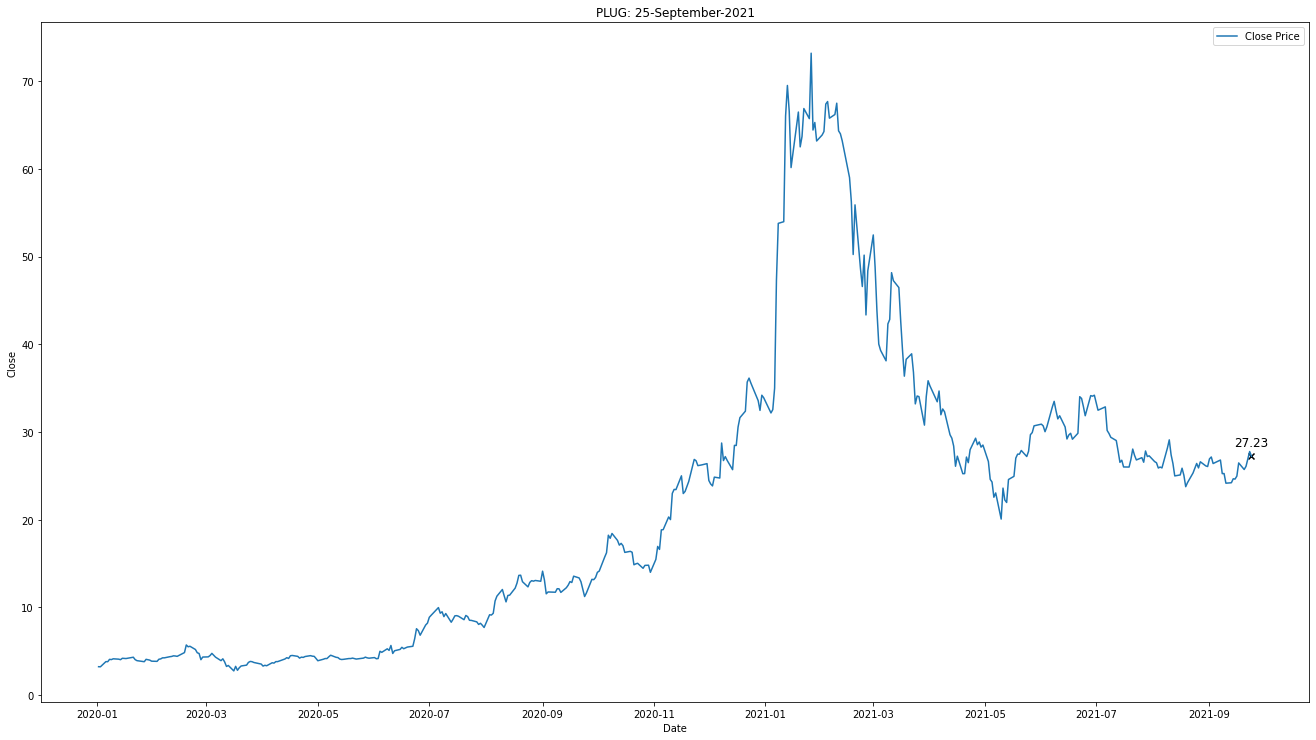

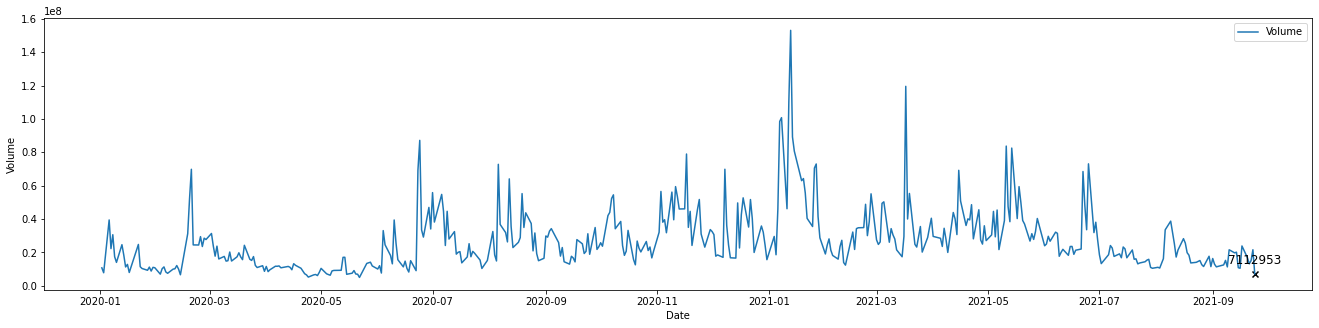


Menu:
Press 1: Simple Moving Average Visualizer
Press 2: Relative Strength Index
Press 3: Bollinger Bands
Press 4: MACD
Press 5: Fibonacci Retracement
Press 6: Average True Range: Volatility Indicator
Press 7: RSI-Bollinger Strategy
Press 8: Aroon Indicators
Press 9: Stochastic Oscillator
Type in '10': Moving Average-Stochastic Oscillator Strategy
Type in '11': Ichimoku Cloud Strategy 


 11


<Figure size 432x288 with 0 Axes>

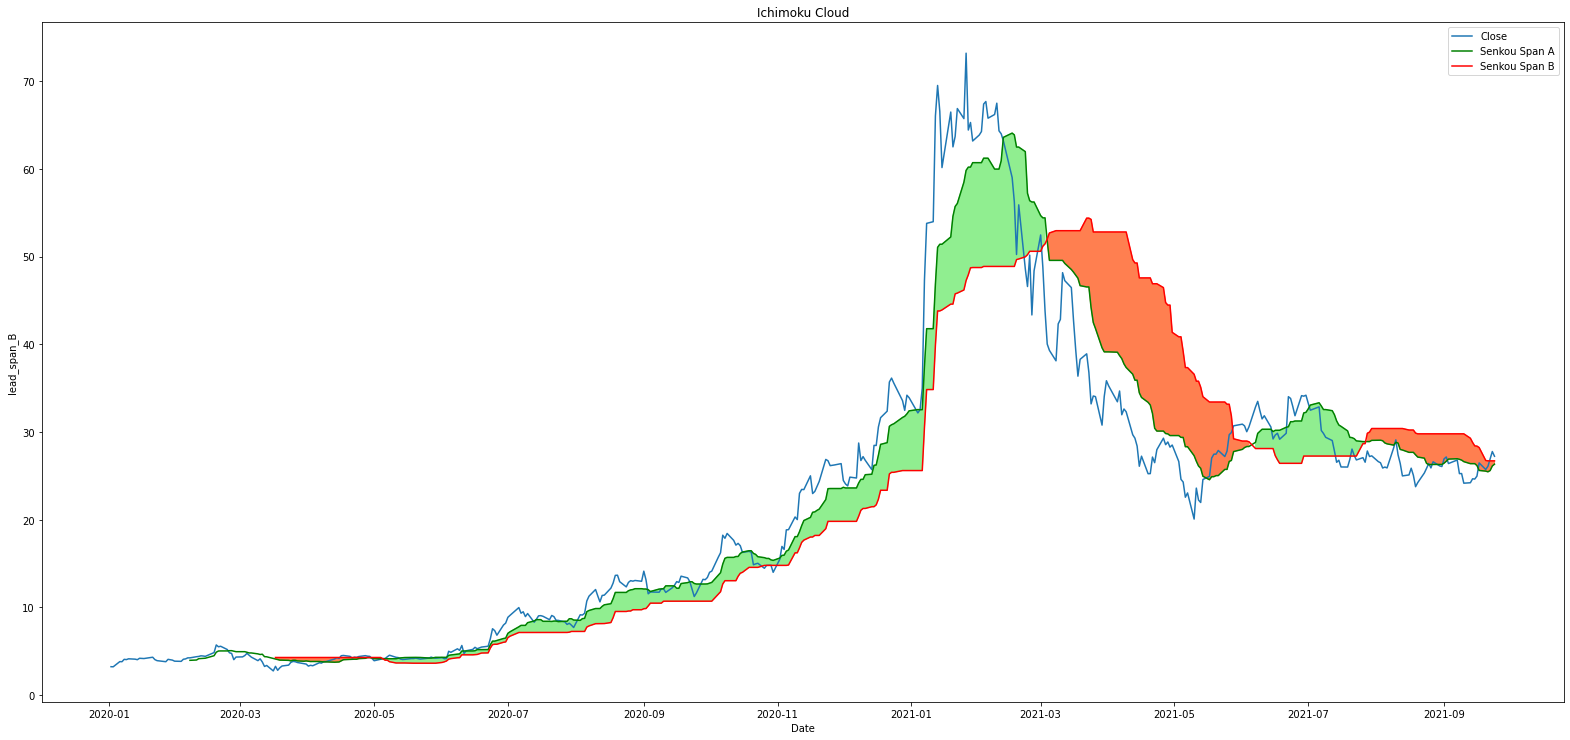

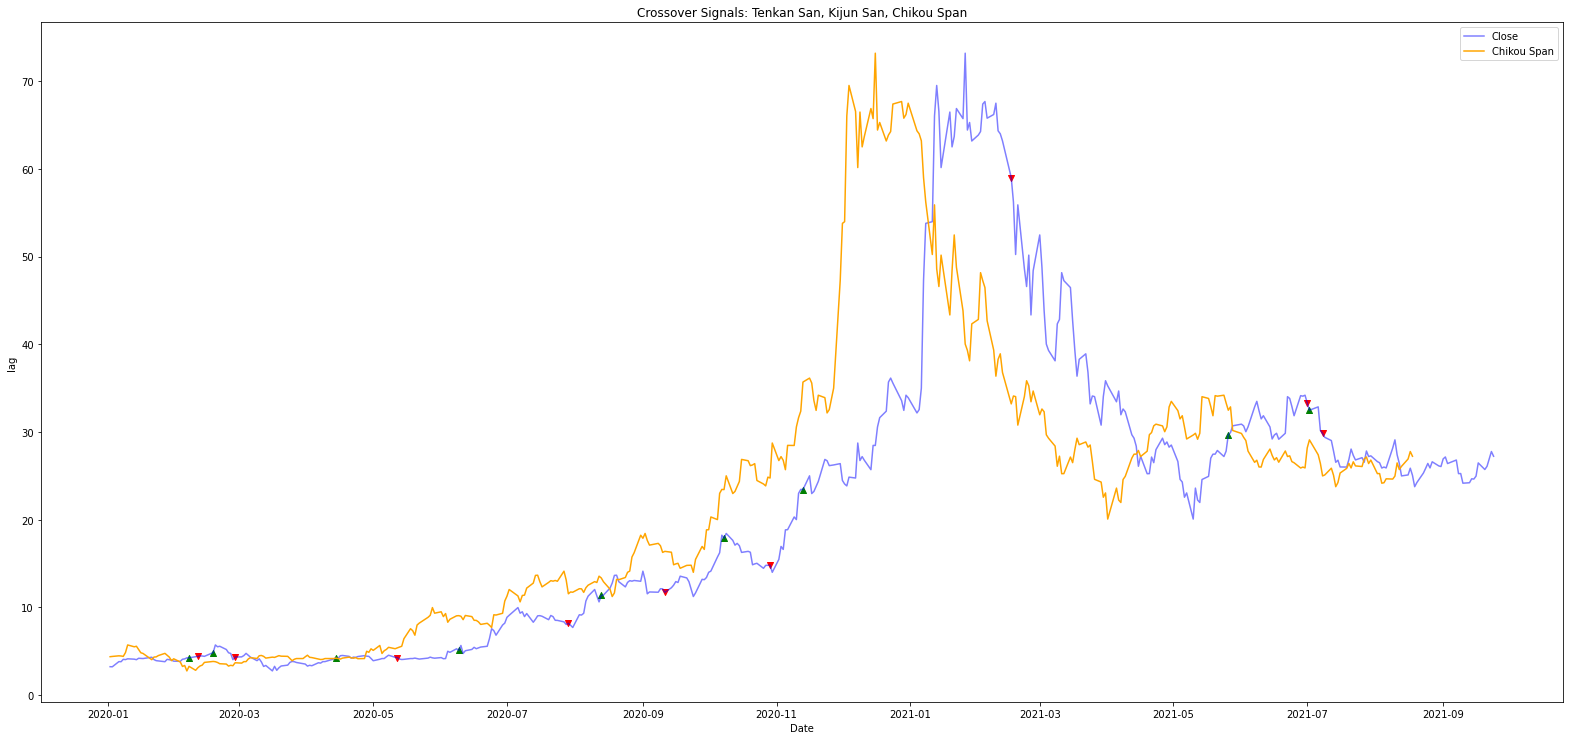

Would you like to continue? Type 1 for 'Yes', 0 for 'no' 0


In [34]:
## import matplotlib.pyplot as plt
if __name__ == "__main__":
    
    welcome_input = int(input("Welcome! Type 1 to continue, 0 to exit"))
    
    while (welcome_input != 0):
        #Set status to 'buy' or 'sell' for signal prices
        tick_symbol = input("Ticker Symbol: ")
        start_date = input("Start Date (YYYY-MM-DD): ")
        end_date = datetime.today().strftime('%Y-%m-%d')
        data = read_data(tick_symbol, start_date, end_date)
        #show_fundamentals(tick_symbol)
        show_initial_info(data, tick_symbol)
        
        print("\nMenu:")
        print("Press 1: Simple Moving Average Visualizer")
        print("Press 2: Relative Strength Index")
        print("Press 3: Bollinger Bands")
        print("Press 4: MACD")
        print("Press 5: Fibonacci Retracement")
        print("Press 6: Average True Range: Volatility Indicator")
        print("Press 7: RSI-Bollinger Strategy")
        print("Press 8: Aroon Indicators")
        print("Press 9: Stochastic Oscillator")
        print("Type in '10': Moving Average-Stochastic Oscillator Strategy")
        print("Type in '11': Ichimoku Cloud Strategy ")
        
        input_menu = int(input())

        if (input_menu == 1):

            status = input("Type 'buy' for Buy Indicator, 'sell' for sell indicators or any other characters for none")
            short_avg = int(input("What is your short moving average period?"))
            long_avg = int(input("What is your long moving average period?"))
            input_user = input("To view previous closing price, type 'y', else 'n'")
            #Set level to 'r' for resistance, 's' for support, 'b' for both 
            levels = input("Press 'r' for resistance levels, 's' for support levels, 'b' for both, else 'n' for nothing")

            #SMA
            generator(data, status, tick_symbol, short_avg, long_avg, levels, input_user) 
        elif (input_menu == 2):
            
            #To activate RSI generator type 'yes'
            #Change time period to your liking 
            time_period = int(input("Time period (in days)"))
            RSI(data, tick_symbol, time_period)

        elif (input_menu == 3):
        
            period_bollinger = int(input("Time period (in days)"))
            Bollinger_Band(data, period_bollinger, tick_symbol)

        elif (input_menu == 4):
           
            short_term = int(input("What is your short term period? (in days)"))
            mid_term = int(input("What is your mid term period? (in days)"))
            long_term = int(input("What is your long term period? (in days)"))
            MACD(data, tick_symbol, short_term, mid_term, long_term)
            
        elif (input_menu == 5):
            
            fibonacci_retracement(data, tick_symbol)
            
        elif (input_menu == 6):
            
            period_atr = int(input('Time period (in days)'))
            ATR(data, tick_symbol, period_atr)
            
        elif (input_menu == 7):
            
            period_RSI = int(input('Time period of RSI (in days)'))
            period_Boll = int(input('Time period of Bollinger Band (in days)'))
            RSI_Bollinger(data, period_Boll, period_RSI, tick_symbol)
            
        elif (input_menu == 8):
            
            period = int(input("Time period (in days)"))
            aroon(data, period)
            
        elif (input_menu == 9):
            
            period = int(input("Time period (in days)"))
            stochastic_oscillator(data, period)
            
        elif (input_menu == 10):
            #specify period of days for RSI
            days_for_stochastic = int(input('Time period of Stochastic Oscillator (in days)'))

            #specify period for bollinger
            days_for_moving_average = int(input('Time period of Simple Moving Average (in days)'))

            days_for_exp_average = int(input('Time period of Exponential Moving Average (in days)'))

            #view results
            MA_Stochastic(data, days_for_moving_average, days_for_exp_average, days_for_stochastic)
    
        elif (input_menu == 11):
            ichimoku_cloud(data)
            
        welcome_input = int(input("Would you like to continue? Type 1 for 'Yes', 0 for 'no'"))
                 
